<a href="https://colab.research.google.com/github/assulthoni/DTI-assignment/blob/main/Text_Mining_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imblearn
!pip install sastrawi

In [2]:
import re
import ast
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [3]:
import requests
import io

response = requests.get('https://raw.githubusercontent.com/ialfina/id-hatespeech-detection/master/IDHSD_RIO_unbalanced_713_2017.txt')
data = io.StringIO(response.text)

In [4]:
df_tweet = pd.read_csv(data,sep='\t')
df_tweet.head()

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


In [5]:
count_label =df_tweet.Label.value_counts().to_frame()
px.bar(data_frame=count_label, x=count_label.index , y='Label')

In [6]:
df_stopwords = pd.read_csv('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_stop_words.txt', header=None)
list_stopwords = list(df_stopwords[0])

slang_word = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt').text
dict_slang = eval(slang_word)

df_acronym = pd.read_csv('https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/acronym.txt', header=None, sep='=')
df_acronym.columns = ['Singkatan', 'kepanjangan']
df_acronym.kepanjangan = df_acronym.kepanjangan.apply(lambda x: x.strip().lower())
df_acronym.Singkatan = df_acronym.Singkatan.apply(lambda x: x.strip().lower())
dict_singkatan = pd.Series(df_acronym.kepanjangan.values,index=df_acronym.Singkatan).to_dict()
# dict_singkatan['mendagri'] = "menteri dalam negeri"
# dict_singkatan['dki'] = 'jakarta'

dict_clean = {**dict_singkatan, **dict_slang}

In [7]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [8]:
def text_cleansing(text):
  pat1 = r'@[A-Za-z0-9]+'
  pat2 = r'https?://[A-Za-z0-9./]+'
  pat3 = r'RT '
  combined_pat = r'|'.join((pat1, pat2, pat3))
  clean_text = re.sub(combined_pat, '', text)
  clean_text = re.sub("[^a-zA-Z]", " ", clean_text)
  clean_text = " ".join(clean_text.split())
  result = clean_text.lower()
  return result

def preprocessing_slang_singkatan(text, dict_clean=dict_clean):
  regex = r"\b(?:"+"|".join(re.escape(word) for word in dict_clean) + r")\b"
  reobj = re.compile(regex, re.I)
  
  return reobj.sub(lambda x:dict_clean[x.group(0)], text)

def remove_stopwords(x, list_stopwords=list_stopwords):
  return " ".join([w for w in x.split() if not w in list_stopwords])

def stem_text(x, stemmer=stemmer):
  return stemmer.stem(x)

def clean_all(x, dict_clean=dict_clean, list_stopwords=list_stopwords, stemmer=stemmer):
  x = text_cleansing(x)
  x = preprocessing_slang_singkatan(x, dict_clean=dict_clean)
  # x = stem_text(x, stemmer=stemmer)
  x = remove_stopwords(x, list_stopwords=list_stopwords)
  return x


In [9]:
tqdm.pandas()

In [10]:
clean_all('berak ah dki jakarta')

'berak ah daerah ibu kota jakarta'

In [11]:
df_tweet['clean'] = df_tweet.Tweet.progress_apply(lambda x: clean_all(x, dict_clean=dict_clean,
                                                      stemmer=stemmer,
                                                      list_stopwords=list_stopwords))

100%|██████████| 713/713 [00:05<00:00, 127.12it/s]


In [12]:
df_tweet['y'] = df_tweet.Label.map({'HS' : 1, 'Non_HS' : 0})
df_tweet.head()

,Label,Tweet,clean,y
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,fadli zon menteri dalam negeri menonaktifkan a...,0
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,melukai aksi dalam rangka memenjarakan ahok ah...,0
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi gurbernur melakukan kekerasan perempuan ...,0
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",ahmad dhani puas debat pemilihan kepala daerah...,0
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,waspada kartu tanda penduduk palsu kawal pemil...,0


In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_tweet.clean)
y = np.array(df_tweet.y.values)

In [14]:
sampler = SMOTE()
X, y = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
                   X, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape , X_test.shape , y_test.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



((607, 2590), (607,), (299, 2590), (299,))

In [15]:
type(X_train.toarray())

numpy.ndarray

In [16]:
svm_classifier = SVC().fit(X_train, y_train)
nb_classifier = GaussianNB().fit(X_train.toarray(), y_train)
logreg_classifier = LogisticRegression().fit(X_train, y_train)

In [17]:
print(classification_report(y_test, svm_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       153
           1       0.97      0.84      0.90       146

    accuracy                           0.91       299
   macro avg       0.91      0.90      0.91       299
weighted avg       0.91      0.91      0.91       299



In [18]:
print(classification_report(y_test, nb_classifier.predict(X_test.toarray())))

              precision    recall  f1-score   support

           0       0.88      0.65      0.75       153
           1       0.71      0.90      0.80       146

    accuracy                           0.78       299
   macro avg       0.80      0.78      0.77       299
weighted avg       0.80      0.78      0.77       299



In [19]:
print(classification_report(y_test, logreg_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.89       153
           1       0.91      0.86      0.88       146

    accuracy                           0.89       299
   macro avg       0.89      0.89      0.89       299
weighted avg       0.89      0.89      0.89       299



best model is Support Vector Machine

Text(0.5, 1.0, 'confusion matrix of SVM Classifier')

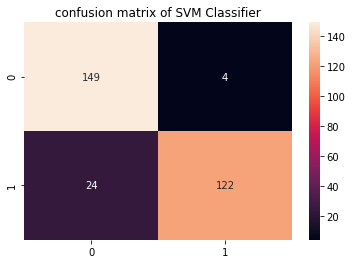

In [20]:
sns.heatmap(confusion_matrix(y_test, svm_classifier.predict(X_test)), annot=True, fmt='d')
plt.title("confusion matrix of SVM Classifier")